In [18]:
from cmdstanpy import CmdStanModel
import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd
import statistics as s 

import matplotlib.pyplot as plt
import matplotlib as mpl

Task 1

In [19]:
#Observed data
x_obs = [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10]
y_obs = [0.328572824089476, 4.20607004111644, 1.35507551134795,
0.161608755204364, -5.42320349780782, -3.05851276224202, -0.0764172642034502,
-4.55218472276499, -0.902226297922731, -5.8609833528976, -1.05854090910473]

In [20]:
x_predict = np.linspace(-11,11,551,endpoint=True)
observed_idx = [26, 76, 126, 176, 226, 276, 326, 376, 426, 476, 526]

In [21]:
for asd in observed_idx:
    print(x_predict[asd])

-9.96
-7.96
-5.96
-3.96
-1.959999999999999
0.040000000000000924
2.040000000000001
4.040000000000001
6.039999999999999
8.04
10.04


In [22]:
alpha = 3
rho = 5.5
sigma = 2

In [23]:
model = CmdStanModel(stan_file='gaussian_process.stan')

INFO:cmdstanpy:compiling stan file /Users/piotrszyller/Documents/2ndLv/s01/DataAnalytics/L06/gaussian_process.stan to exe file /Users/piotrszyller/Documents/2ndLv/s01/DataAnalytics/L06/gaussian_process










































































































































































INFO:cmdstanpy:compiled model executable: /Users/piotrszyller/Documents/2ndLv/s01/DataAnalytics/L06/gaussian_process
--- Translating Stan model to C++ code ---
bin/stanc  --o=/Users/piotrszyller/Documents/2ndLv/s01/DataAnalytics/L06/gaussian_process.hpp /Users/piotrszyller/Documents/2ndLv/s01/DataAnalytics/L06/gaussian_process.stan
Warning in '/Users/piotrszyller/Documents/2ndLv/s01/DataAnalytics/L06/gaussian_process.stan', line 3, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can 

In [24]:
data=dict(
    N_predict=len(x_predict),
    x_predict=x_predict,
    N_obs=len(y_obs),
    y_obs=y_obs,
    observed_idx=observed_idx,
    rho=rho,
    alpha=alpha,
    sigma=sigma
)

result = model.sample(data=data, chains = 4)

INFO:cmdstanpy:CmdStan start processing



































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































INFO:cmdstanpy:CmdStan done processing.


In [25]:
result.summary()
print(len(result.stan_variable('y_predict')[0,:]))
print(len(result.stan_variable('y_predict')[:,0]))

551
4000


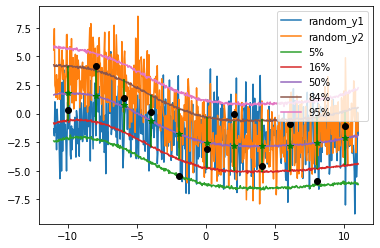

In [26]:
med_prob_ppc = np.percentile(result.stan_variable('y_predict'),[5,16,50,84,95],axis=0)
plt.plot(x_predict,result.stan_variable('y_predict')[100])
plt.plot(x_predict,result.stan_variable('y_predict')[200])
plt.plot(x_predict,med_prob_ppc[0])
plt.plot(x_predict,med_prob_ppc[1])
plt.plot(x_predict,med_prob_ppc[2])
plt.plot(x_predict,med_prob_ppc[3])
plt.plot(x_predict,med_prob_ppc[4])
labels= ["random_y1","random_y2", "5%", "16%", "50%", "84%", "95%"]
plt.legend(labels)

plt.scatter(x_predict[observed_idx], y_obs, color='black', zorder=5)
plt.errorbar(x_predict[observed_idx], med_prob_ppc[2][observed_idx], (med_prob_ppc[2]-med_prob_ppc[1])[observed_idx],fmt='*', color='green')

plt.show()

In [27]:
len(result.stan_variable('y_predict')[0])

551

In [28]:
len(med_prob_ppc[2]-med_prob_ppc[1])

551

Task 2: optimize hyperparameters
To achive better results of GP fitting for our observed data, we need to oprimize its parameters. We can do that by using maximum marginal likelihood estimation. It can be done by placing parameters in "parameter" block in stan model and using "optimize" method.

In [29]:
model2 = CmdStanModel(stan_file='gaussian_process_optimize.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [30]:
data2=dict(
    N_obs=len(x_obs),
    x_obs=x_obs,
    y_obs=y_obs,
)

In [31]:
result2 = model2.optimize(data=data2, seed=5838298)
optimized_rho=(result2.stan_variable('rho'))
optimized_alpha=(result2.stan_variable('alpha'))
optimized_sigma=(result2.stan_variable('sigma'))

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [32]:
data3=dict(
    N_predict=len(x_predict),
    x_predict=x_predict,
    N_obs=len(y_obs),
    y_obs=y_obs,
    observed_idx=observed_idx,
    rho=optimized_rho,
    alpha=optimized_alpha,
    sigma=optimized_sigma
)

In [33]:
result3 = model.sample(data=data3, chains = 4)

INFO:cmdstanpy:CmdStan start processing


































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































INFO:cmdstanpy:CmdStan done processing.


In [34]:
result3.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-280.0000,0.4500,17.00,-310.0,-280.000,-250.0,1400.0,2.5,1.0
f_tilde[1],-0.1000,0.0088,0.73,-1.3,-0.110,1.1,6866.0,13.0,1.0
f_tilde[2],0.0100,0.0091,0.80,-1.3,0.029,1.3,7673.0,14.0,1.0
f_tilde[3],0.1700,0.0090,0.94,-1.4,0.170,1.7,11017.0,20.0,1.0
f_tilde[4],0.3300,0.0098,0.96,-1.2,0.350,1.9,9625.0,18.0,1.0
...,...,...,...,...,...,...,...,...,...
y_predict[547],-0.0640,0.0220,2.10,-3.5,-0.058,3.3,9045.0,17.0,1.0
y_predict[548],-0.0460,0.0220,2.10,-3.5,-0.050,3.5,8968.0,16.0,1.0
y_predict[549],-0.0270,0.0230,2.20,-3.7,-0.003,3.6,9124.0,17.0,1.0


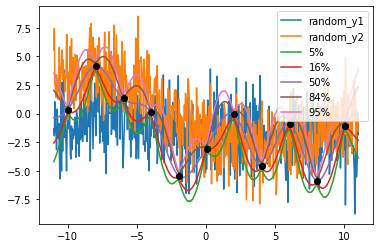

In [35]:
med_prob_ppc3 = np.percentile(result3.stan_variable('y_predict'),[5,16,50,84,95],axis=0)
plt.plot(x_predict,result.stan_variable('y_predict')[100])
plt.plot(x_predict,result.stan_variable('y_predict')[200])
plt.plot(x_predict,med_prob_ppc3[0])
plt.plot(x_predict,med_prob_ppc3[1])
plt.plot(x_predict,med_prob_ppc3[2])
plt.plot(x_predict,med_prob_ppc3[3])
plt.plot(x_predict,med_prob_ppc3[4])
labels= ["random_y1","random_y2", "5%", "16%", "50%", "84%", "95%"]
plt.legend(labels)
plt.scatter(x_predict[observed_idx], y_obs, color='black', zorder=5)
plt.errorbar(x_predict[observed_idx], med_prob_ppc3[2][observed_idx], (med_prob_ppc3[2]-med_prob_ppc3[1])[observed_idx],fmt='*', color='green')
plt.show()